# Introduction
## Defining the Problem
Hotels are an important part of the travel and hospitality industry. Customer reviews and responding to them have always been a vital part of the hotel industry. Reviews is a way for travlers to share their experience with other potential hotel guests which can generally influence the decision on hotel choices by future travelers. Reading off the reviews help to gain a better understanding for the general public's perception of the hotel.

Data quality and quantity may be a limiting factor when performing an in-depth analysis on all hotel review data. Hence, this project would be using a small amount of datset to classify hotel reviews as positive,neutral or negative based on the text content of the review and its rating type assigned to it. The model can be used in different ways such as send a flag to the hotel organization when a review is classified as negative. 

### Data Quantity
The dataset used may not contain all type of positive or negative reviews, the labels might be limited and not specific where the neutral reviews is hard to classify it as positive and negative review.

### Data Quality
The dataset used is might not be up to date. Hotels guests might have different expection between now and last time. 

## Assembling a Dataset
In this project, we will be using dataset call trip advisor hotel reviews from Kaggle. From this dataset, we will be predict which type of hotel reviews does the review belong to. The dataset contains the review and the rating by the past customers of the hotels on tripadvisor. The type of review is generated by the rating left with the reviews. The rating for the reviews higher than 3 will be classifed as Positive review, the rating lower than 3 will be classified as negative review and rating of 3 will be neutral. 

In addition, the dataset is a multiclass, single-label classification which means that the last-layer activation would be done using softmax and the loss function will be calculated using 'categorical_crossentropy'.

# Preparing of data

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
from keras.utils import np_utils
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.regularizers import l1
import tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall, AUC

import itertools
import matplotlib.pyplot as plt

seed = 204

tensorflow.random.set_seed(seed)
np.random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

## Data Loading
After importing the necessary libraries to be used in the project, we important our dataset using pandas library. This gives use the data in dataframe format.

In [2]:
df = pd.read_csv("hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Data Preprocessing
After the data is imported, we classify the review type for for review by its respective rating.

In [3]:
conditions=[(df['Rating']<3),(df['Rating'] == 3),(df['Rating']>3)]
review_type = ['Negative','Netrual','Positive']
df["Rating_type"] = np.select(conditions,review_type)
df.head()

,Review,Rating,Rating_type
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Netrual
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive


The rating column will be removed since we are only using the review and rating_type column for the model.

In [4]:
df = df.drop(columns=['Rating'])

To ensure that the data used is clean, we check for na values and if there is any duplicate.

In [5]:
#check for na values
df.isna().any()

Review         False
Rating_type    False
dtype: bool

In [6]:
#check for number of rows and col the dataset have
df.shape

(20491, 2)

In [7]:
# check if there is any duplicate of review
df.nunique()

Review         20491
Rating_type        3
dtype: int64

## Data Splitting
The data will split 10% of it into testing set while the rest will be training set.

In [8]:
test_size = 0.1

(reviews_train, reviews_test, 
 rating_train, rating_test) = train_test_split(df['Review'], df['Rating_type'], 
                                                     test_size=test_size, stratify=df['Rating_type'],
                                                     shuffle=True, random_state=seed)

## Vectorize the dataset
The reviews in the train data will be vectorized by turning it into vectors and preprocessing it in a way that makes it more easily approached by a neural network. Tfidf will be used to converts dataset into vectors and each work will has its own vector. The labels will also need to be vectorise.

In [9]:
MAX_FEATURES = 5000
NGRAMS = 2

# turn text into features
tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(reviews_train)

#make the vector into array
X_train, X_test = tfidf.transform(reviews_train).toarray(), tfidf.transform(reviews_test).toarray()


In [10]:
#encode the target labels with values between 0 and 1
label_encoder = LabelEncoder()
label_encoder.fit(df['Rating_type'])
#transform the labels into vector that contain values between 0 and 1
y_train = np_utils.to_categorical(label_encoder.transform(rating_train))
y_test = np_utils.to_categorical(label_encoder.transform(rating_test))

In [11]:
#split the training dataset to train data and validation data
test_size = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=test_size, stratify=y_train,
                                                 shuffle=True, random_state=seed)

## Optimizer
For this project, RMSProp optimizer is used as it is a better optimization schemes. Rmsprop is a gradient-based optimization technique where it uses the moving average of squared gradients to normalize the gradient itself. RMSProp is a good choice for optimizer whatever the problem is hence I believe it would be suited for this proejct.  In this project, we will used RMSProp optimizer with its default learning rate.

## Measure of success
Function that plot thr loss and auc is created in the project when buildung a model. This will help in analysing both graphs and ensure that the model is performing as accurately as possible. 

With the class-imbalanced problem, precision and recall is used to determine if the model is good or anot. Since the dataset is splited into train, validation and test sets hence we will use loss functions that map predicted probabilities and corresponding observed outcomes to loss value which are minimized in expectation by true probabilities.

To ensure the good performance of the model, we will plot loss graph when building and improving on our models to ensure that the model is underfit/overfit/goodfit. 

# Developing model
After making the input data and labels to a vector, we can proceed to build the model. Before that, we need to find out the baseline of the model. Simply by using the most frequently occuring label in the dataset which is Positive and use this label to find the probability of finding that label from the dataset.
## Baseline

In [12]:
counts = df.groupby(['Rating_type']).count()
counts.reset_index(inplace=True)

counts

,Rating_type,Review
0,Negative,3214
1,Netrual,2184
2,Positive,15093


In [13]:
baseline_naive = counts[counts['Rating_type']=='Positive']['Review'].values[0] / counts['Review'].sum()
baseline_naive

0.7365672734371187

In [14]:
base=balanced_accuracy_score(y_train.argmax(axis=1), np.zeros(len(y_train)))
base

0.3333333333333333

The baseline found is around 74%. hence a model better accuracy score than 74% need to be developed.

## Define Functions
### Function to build neutral network model
The function is used to created a model.

In [15]:
def create_model(hidden_layers=0 , hidden_neurons=np.nan , activation=None , dropout = np.nan,
                       input_dimension = 2 , output_dimension = 1 , optimizer = 'rmsprop' , loss='categorical_crossentropy' ,
                       regularizer=None , metrics=['accuracy']):

    model = Sequential()

    for layer in range(hidden_layers):
        model.add(Dense(hidden_neurons , activation = activation , input_shape = 'default' if layer>1 else (input_dimension,)
                        , kernel_regularizer = regularizer if regularizer!=None else None))

        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))

    model.add(Dense(output_dimension , activation = 'sigmoid' if output_dimension==1 else 'softmax',
                    input_shape = 'default' if hidden_layers>0 else (input_dimension, )))
    
    model.compile(optimizer = optimizer , loss=loss , metrics=metrics)
    
    return model

### Function to train the model
The function is used to train the model

In [16]:
def train_model(model , X , y , class_weights , batch_size=32 ,
                             epochs=100 , val_data=None , callbacks=[] , seed=0):
    if val_data is None :
        X_train , X_val , y_train , y_val = train_test_split(X,y,test_size=0.2,random_state=seed , 
                                                            shuffle = True , stratify=y)
    else:
        X_train , X_val , y_train , y_val = X , val_data[0] , y , val_data[1]
        
    history = model.fit(X_train , y_train , class_weight=class_weights , batch_size = batch_size , epochs = epochs , 
                       validation_data=(X_val,y_val) , callbacks = callbacks , verbose = 0 )
    
    return {'model':model , 
            'validation score': model.evaluate(X_val , y_val , verbose=0)[1:] ,
            'history' : history}

### Function to plot the graph
The function is used to show the model's training history.

In [17]:
def plot_training_history(history, monitor='loss') :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    epochs = range(1, len(loss)+1)
    #assign values for each axis
    plt.plot(epochs, loss, 'bo', label=monitor)
    plt.plot(epochs, val_loss, 'b', label='Validation ' + monitor)
    plt.xlim([0, len(loss)])
    plt.title('Training and Validation ' + monitor + 's')
    plt.xlabel('Epochs')
    plt.ylabel(monitor)
    plt.legend()
    plt.grid()
    _ = plt.show()

## Parameters of the model
Identify the class weight and assign it to model so that class with higher class-weight can have more emphasis on the class

In [18]:
# assign class weights to model
labels = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight = dict(enumerate(weights))

class_weight

{0: 2.1251134448333984, 1: 3.127456592253387, 2: 0.4525525276788426}

In [19]:
#number of features
input_dimension = X_train.shape[1]
#number of classes
output_class = y_train.shape[1]

optimizer = 'rmsprop'
loss_function = 'categorical_crossentropy'
metrics = ['categorical_accuracy', 
           Precision(name='precision'), 
           Recall(name='recall'),
           AUC(name='auc', multi_label=True),
          ]


Adding early stopping callback can help to prevent the model overfits the data. With this, the model will stop training with the data when the validation result is got worse.

In [20]:
monitor = 'val_loss'
patience = 5

EARLY_STOP = EarlyStopping(monitor=monitor, restore_best_weights=True, patience=patience, verbose=0)

Early stopping will interrupting training when the validation loss is no longer
improving.

# Evaluation Protocol 1: Hold-Out
In most cases, hold out validation is sufficient for our models. So, we will first attempt to create amodel using the hold-out method.
## Underfit Model
The first model would be fairly simple, having the minimum requirements that we need to have statistical power which is to have an accuracy higher than 0.7. Our model will only have required the last activation layer softmax and the loss function categorical_crossentropy.

In [21]:
baseline = create_model(hidden_layers=0,
                                  input_dimension=input_dimension,
                                  output_dimension=output_class,
                                  optimizer=optimizer,loss=loss_function,
                                  metrics=metrics)

baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 15003     
                                                                 
Total params: 15,003
Trainable params: 15,003
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train the model
baseline_model = train_model(baseline , X_train , 
                                                 y_train , class_weight ,
                                                 batch_size=128 ,
                                                 epochs=10 , val_data=(X_val,y_val),
                                                 seed=seed , callbacks=[])


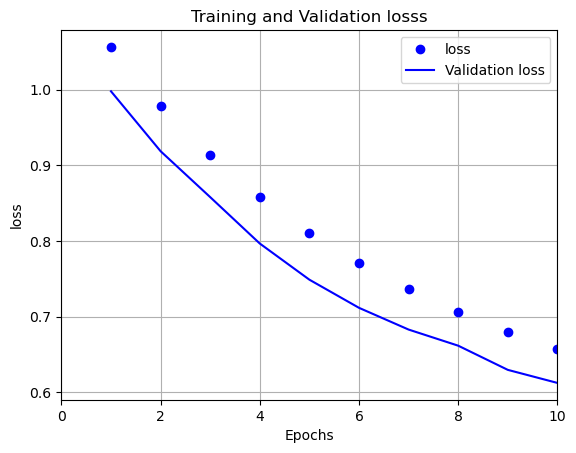

In [23]:
plot_training_history(baseline_model['history'], monitor='loss')

In [24]:
print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(baseline_model['validation score'][0], baseline_naive))
print('Precision (Validation): {:.2f}'.format(baseline_model['validation score'][1]))
print('Recall (Validation): {:.2f}'.format(baseline_model['validation score'][2]))
print('AUC (Validation): {:.2f}'.format(baseline_model['validation score'][3]))


Accuracy (Validation): 0.82 (Naive Baseline=0.74)
Precision (Validation): 0.92
Recall (Validation): 0.65
AUC (Validation): 0.92


As shown above, our accuracy has a value of 82% despited the underfitting model. This is sufficient to beat our baseline of 74%. Now, we will create a model that overfits. 

## Overfits model
After developing a model that is able to do better than the baseline, we need to develop a model that overfits. As the aim of this project is to create a model that stands on the line between overfitting and underfitting, we now need to cross the line to develop a model that overfits.

Here, we would be making the model bigger or increasing the training until the model's performance on the validation data starts degrading. This is when overfitting has been achieved.

In [25]:
#opt = RMSprop(learning_rate=0.001)

In [26]:
# adding more hidden layers and neurons in the neural network to achieve overfit
overfit = create_model(hidden_layers=3 , hidden_neurons = 64 ,
                                           activation = 'relu' , input_dimension = input_dimension ,
                                           output_dimension = output_class , optimizer ='rmsprop',
                                           loss = loss_function , metrics=metrics)

overfit.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 328,579
Trainable params: 328,579
Non-trainable params: 0
_________________________________________________________________


In [27]:
# train the scaled up model
overfit_model = train_model(overfit,X_train , y_train , 
                                             class_weight , batch_size = 100 ,
                                             epochs=40 , val_data =(X_val,y_val) ,
                                             seed=seed , callbacks=[])


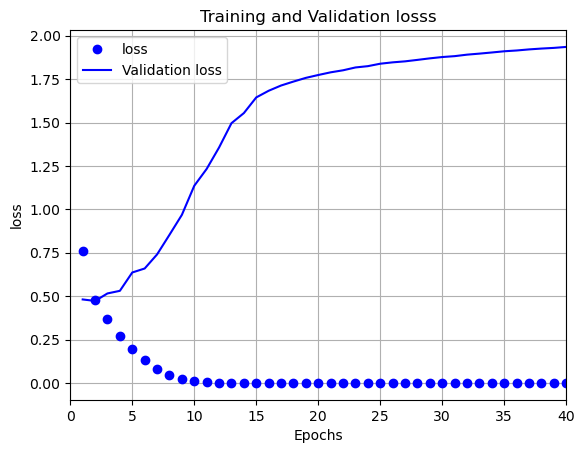

In [28]:
plot_training_history(overfit_model['history'], monitor='loss')

From the plotted training and valiadation graph above, we can tell that validation loss is lowest at epoch three. However, the model has been over-trained as it fits the training set very closely and begins to fail on the unseen validation data.

In [29]:
print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(overfit_model['validation score'][0], baseline_naive))
print('Precision (Validation): {:.2f}'.format(overfit_model['validation score'][1]))
print('Recall (Validation): {:.2f}'.format(overfit_model['validation score'][2]))
print('AUC (Validation): {:.2f}'.format(overfit_model['validation score'][3]))


Accuracy (Validation): 0.83 (Naive Baseline=0.74)
Precision (Validation): 0.83
Recall (Validation): 0.83
AUC (Validation): 0.80


From the evaluation, accuracy of the overfit model is the same as the underfit model at 82%. However, the plotted graph shows severe overfitting as seen from the large difference between the training and validation loss and accuracy. We can see that the Recall has increases but the precision has dropped.

# Regularizing your model 
After creating a model that overfits, we need to modify the model until the line we mentioned above, is found. This can be done using various methods which we will be further exploring in this project.


# Method 1: DropOut

In [30]:

dropout = create_model(hidden_layers=1 , hidden_neurons = 64 ,
                                           activation = 'relu' , input_dimension = input_dimension ,dropout=0.5,
                                           output_dimension = output_class , optimizer ='rmsprop',
                                           loss = loss_function , metrics=metrics)

dropout.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [31]:
dropout_model = train_model(dropout,X_train , y_train , 
                                             class_weight , batch_size = 128 ,
                                             epochs=40 , val_data =(X_val,y_val) ,
                                             seed=seed , callbacks=[])


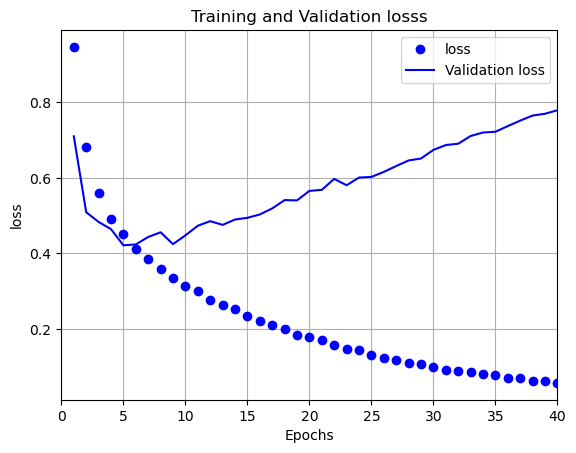

In [32]:
plot_training_history(dropout_model['history'], monitor='loss')

In [33]:
print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(dropout_model['validation score'][0], baseline_naive))
print('Precision (Validation): {:.2f}'.format(dropout_model['validation score'][1]))
print('Recall (Validation): {:.2f}'.format(dropout_model['validation score'][2]))
print('AUC (Validation): {:.2f}'.format(dropout_model['validation score'][3]))


Accuracy (Validation): 0.81 (Naive Baseline=0.74)
Precision (Validation): 0.81
Recall (Validation): 0.80
AUC (Validation): 0.87


## Method 2: Add L1 and/or L2 regularization

In [34]:
l2r = create_model(hidden_layers=1 , hidden_neurons = 64 ,
                                 activation = 'relu' ,
                                 input_dimension=input_dimension , 
                                 output_dimension=output_class , 
                                 regularizer = l2(0.001) ,
                                 optimizer=optimizer , loss=loss_function ,
                                 metrics = metrics)
l2r.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                320064    
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [35]:
l2r_model = train_model(l2r,X_train , y_train , 
                                             class_weight , batch_size = 128 ,
                                             epochs=40 , val_data =(X_val,y_val) ,
                                             seed=seed , callbacks=[])

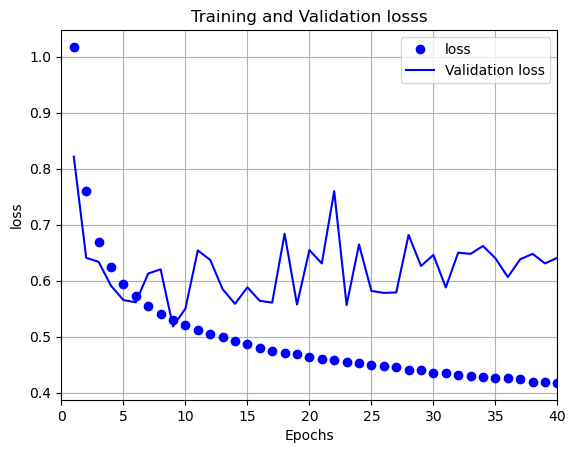

In [36]:
plot_training_history(l2r_model['history'], monitor='loss')

In [37]:
print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(l2r_model['validation score'][0], baseline_naive))
print('Precision (Validation): {:.2f}'.format(l2r_model['validation score'][1]))
print('Recall (Validation): {:.2f}'.format(l2r_model['validation score'][2]))
print('AUC (Validation): {:.2f}'.format(l2r_model['validation score'][3]))


Accuracy (Validation): 0.80 (Naive Baseline=0.74)
Precision (Validation): 0.82
Recall (Validation): 0.79
AUC (Validation): 0.90


## Combine the previous few methods

In [58]:
model = create_model(hidden_layers=1 , hidden_neurons = 64 ,
                                 activation = 'relu' , dropout=0.5,
                                 input_dimension=input_dimension , 
                                 output_dimension=output_class , 
                                 regularizer = l1(0.001) ,
                                 optimizer=optimizer , loss=loss_function ,
                                 metrics = metrics)
model.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_221 (Dense)           (None, 64)                320064    
                                                                 
 dropout_126 (Dropout)       (None, 64)                0         
                                                                 
 dense_222 (Dense)           (None, 3)                 195       
                                                                 
Total params: 320,259
Trainable params: 320,259
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_train = train_model(model,X_train , y_train , 
                                             class_weight , batch_size = 128 ,
                                             epochs=40 , val_data =(X_val,y_val) ,
                                             seed=seed , callbacks=[])

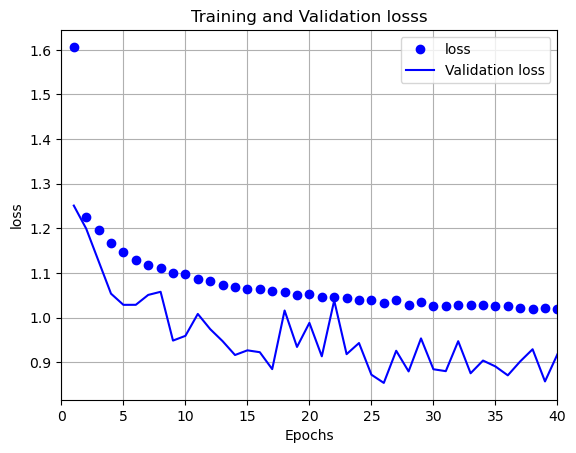

In [60]:
plot_training_history(model_train['history'], monitor='loss')

From the plotted graphs, we can see that we had achieved a model with a good fit where training and validation curves are close to one another.

In [61]:
print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(model_train['validation score'][0], baseline_naive))
print('Precision (Validation): {:.2f}'.format(model_train['validation score'][1]))
print('Recall (Validation): {:.2f}'.format(model_train['validation score'][2]))
print('AUC (Validation): {:.2f}'.format(model_train['validation score'][3]))


Accuracy (Validation): 0.77 (Naive Baseline=0.74)
Precision (Validation): 0.85
Recall (Validation): 0.67
AUC (Validation): 0.90


We can see that the accuracy value has dropped a lot however it is still better than baseline but the precision value is quite decent.

# Find the best model
From above combination of the dropout and regularizer help to incraese the accuracy of the model. Hence, i decided to use k-fold cross validation to be the evaluation protocol where there will be a series of different parameters use to train and validate the model. Then, choose the parameter that give the best result as the final model.

In [44]:
# function that turns the hyperparameters and the evaluation score into dataframe
def to_dataframe(stats,mapping) :
    entries = []
    for param , metrics in stats.items():
        entry = eval(param)
        for key , value in metrics.items():
            entry[key] = value
        for key , value in mapping.items():
            entry[value] = entry['scores'][key]
        entry.pop('scores')
        entries.append(entry)
    return pd.DataFrame(data=entries)

In [46]:
# grid search function to search for the best hyperparamters
def grid_search(X , y , class_weights , params , k , optimizer , loss , metrics ,
                seed , epochs , order ={} , callbacks=[]):
    keys,values = zip(*params.items())
    
    stats = {}
    for params in [dict(zip(keys,v)) for v in itertools.product(*values)]:
        #object that can stratify the dataset into k parts
        kfold = StratifiedKFold(n_splits = k , shuffle=True , random_state = seed)
        #scores of the parameters
        scores , stopped , losses = [] , [] , []

        for train , validate in kfold.split(X,y.argmax(axis=1)):

            model = create_model(hidden_layers=params['hidden_layers'],
                                        hidden_neurons=params['neurons'],
                                        activation = params['activation'],
                                        dropout=params['dropout'],
                                        regularizer=l1(0.001) if params['regularizers'] == 'l1' else l2(0.001),
                                        input_dimension=X.shape[1],
                                        output_dimension =1 if len(y.shape)<2 else y.shape[1],
                                        optimizer = optimizer , loss=loss,
                                        metrics = metrics)

            trained = train_model(model , X[train,:] , y[train] , 
                                               class_weights , batch_size=params['batch_size'] , 
                                               epochs = epochs , val_data=(X[validate,:] , y[validate,:]),
                                               seed = seed , callbacks=callbacks)
            

            evaluations = trained['model'].evaluate(X[validate,:] , y[validate,:] ,verbose = 0)[1:]
    

            scores.append(evaluations)
            stopped.append(len(trained['history'].history['val_loss']))
            losses.append(np.min(trained['history'].history['val_loss']))

        stats[str(params)] = {'scores' : np.mean(scores , axis = 0 ) , 
                              'epochs' : np.mean(stopped) , 
                              'val_loss' : np.mean(losses) }
    return to_dataframe(stats, order)

In [47]:
orders = {
    0:'categorical_accuracy' ,
    1:'precision' , 
    2:'recall' ,
    3:'auc'
}
kfolds=5
params = {
    'hidden_layers' : [1,2],
    'neurons' : [32,64],
    'activation' : ['relu'],
    'dropout' : [0.25 , 0.5],
    'batch_size' : [128],
    'regularizers' : ['l1' , 'l2']
}

In [48]:
stats = grid_search(X_train , y_train , class_weights = class_weight , params = params ,
                       k = kfolds , optimizer=optimizer , loss = loss_function , metrics=metrics ,
                       epochs = 40 , seed=seed, order = orders , callbacks=[EARLY_STOP])
stats.sort_values(by=['auc'] , ascending = False).head(10)

,hidden_layers,neurons,activation,dropout,batch_size,regularizers,epochs,val_loss,categorical_accuracy,precision,recall,auc
13,2,64,relu,0.25,128,l2,8.6,0.555460,0.838570,0.861317,0.814104,0.927121
15,2,64,relu,0.50,128,l2,8.6,0.559249,0.838509,0.869094,0.810200,0.925839
9,2,32,relu,0.25,128,l2,9.6,0.547694,0.831004,0.853315,0.811054,0.925800
7,1,64,relu,0.50,128,l2,15.0,0.566456,0.830455,0.866882,0.792997,0.923684
5,1,64,relu,0.25,128,l2,14.2,0.553055,0.831737,0.865113,0.797023,0.923538
3,1,32,relu,0.50,128,l2,18.8,0.569748,0.823867,0.860325,0.789519,0.923281
11,2,32,relu,0.50,128,l2,11.4,0.558491,0.833140,0.862518,0.809346,0.922635
1,1,32,relu,0.25,128,l2,19.8,0.558792,0.825209,0.852949,0.793546,0.922624
8,2,32,relu,0.25,128,l1,17.6,0.762130,0.811970,0.886079,0.752180,0.905060
10,2,32,relu,0.50,128,l1,23.2,0.774261,0.809530,0.928946,0.720578,0.899579


## Build the best model
Now we have the parameters for best performance model, we will use those parameters to build the best model.

In [49]:
best_model = create_model(hidden_layers=2 , hidden_neurons = 32 ,
                                 dropout=0.25 , activation = 'relu' ,
                                 input_dimension=input_dimension , 
                                 output_dimension=output_class , 
                                 regularizer = l2(0.001) ,
                                 optimizer=optimizer , loss=loss_function ,
                                 metrics = metrics)
best_model.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 32)                160032    
                                                                 
 dropout_123 (Dropout)       (None, 32)                0         
                                                                 
 dense_217 (Dense)           (None, 32)                1056      
                                                                 
 dropout_124 (Dropout)       (None, 32)                0         
                                                                 
 dense_218 (Dense)           (None, 3)                 99        
                                                                 
Total params: 161,187
Trainable params: 161,187
Non-trainable params: 0
_________________________________________________________________


In [50]:
best_model_train = train_model(best_model , X_train , y_train ,
                                               class_weight , batch_size=128 ,
                                               epochs=40 , val_data = (X_val,y_val) , 
                                               callbacks=[EARLY_STOP] , seed = seed)


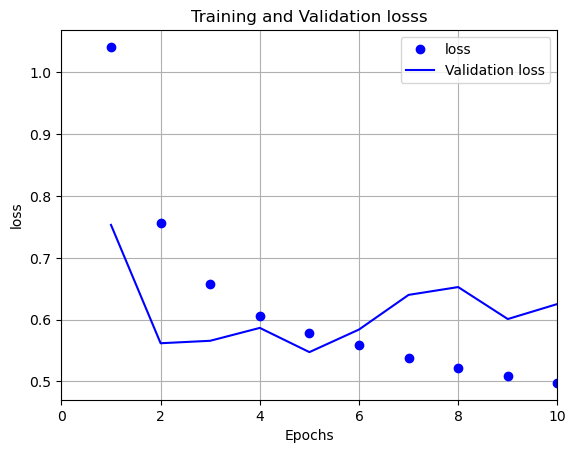

In [51]:
plot_training_history(best_model_train['history'], monitor='loss')

In [52]:
print('Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(best_model_train['validation score'][0], baseline_naive))
print('Precision (Validation): {:.2f}'.format(best_model_train['validation score'][1]))
print('Recall (Validation): {:.2f}'.format(best_model_train['validation score'][2]))
print('AUC (Validation): {:.2f}'.format(best_model_train['validation score'][3]))


Accuracy (Validation): 0.83 (Naive Baseline=0.74)
Precision (Validation): 0.84
Recall (Validation): 0.81
AUC (Validation): 0.92


In [53]:
preds = best_model_train['model'].predict(X_val , verbose=0).argmax(axis=1)
print('Balanced Accuracy (Validation): {:.2f} (Naive Baseline={:.2f})'.format(balanced_accuracy_score(y_val.argmax(axis=1),preds), base))

Balanced Accuracy (Validation): 0.72 (Naive Baseline=0.33)


# Test the model
the best model is tested with the testing set

In [54]:
preds = best_model_train['model'].predict(X_test , verbose=0)
print('Accuracy (Test) : {:.2f} (Naive Baseline={:.2f})'.format(accuracy_score(y_test.argmax(axis=1) ,
                                                                             preds.argmax(axis=1)),baseline_naive))
print('Precision (Test) : {:.2f}'.format(precision_score(y_test.argmax(axis=1) , 
                                                               preds.argmax(axis=1) , 
                                                               average='macro')))
print('Recall (Test) : {:.2f}'.format(recall_score(y_test.argmax(axis=1) , 
                                                         preds.argmax(axis=1) , 
                                                         average='macro')))


Accuracy (Test) : 0.83 (Naive Baseline=0.74)
Precision (Test) : 0.70
Recall (Test) : 0.72


The accuracy of the model had increases, but the precision and recall had dropped.

# Confusion matrix
Confusion matrix which is a breakdown of predictions into a table showing correctpredictions and the types of incorrect predictions made, predictions in the diagonal sectionof the table are the correct predictions

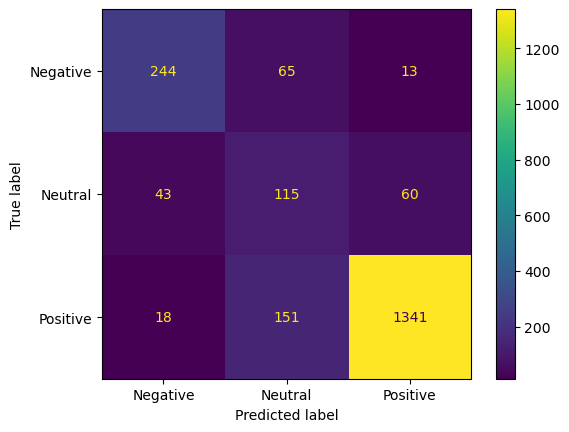

In [56]:
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1)),
                               display_labels=['Negative', 'Neutral', 'Positive'])
conf_matrix.plot()

# Conclusion
I have managed to build the model with the use of hold-out validation and do k-fold cross-validation. The models performed well by having a higher accuracy as the baseline. However, the precision and recall was not very good which means that the model might not be able to retain all the correct result. This might due to the classes "Neutral" by the word itself, we can tell than it is hard to determine if the review is good or bad.

While using RMSprop as the optimizer, categorical_crossentropy as the loss function, the metric is different depending on the evaluation protocol.

During the process of building and training the models, adjusting the hyperparameters is needed to find the best configuration. Hence k-fold validation was used to find the best model.

The general outline of building neutral network protocols are similar as shown above. Overall, the performance of the model created has a decent result.

# References
Larxel (2020) Trip advisor hotel reviews, Kaggle. Available at: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews (Accessed: March 13, 2023). 
